<a href="https://colab.research.google.com/github/Tensor-Reloaded/Tepes.AI/blob/main/05-Vineri/ColabAndHuggingFace.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Utilizarea Google Colab cu GPU și Modele Pre-antrenate de pe Hugging Face

**Google Colab** este o platformă gratuită care permite rularea notebook-urilor Jupyter în cloud, oferind acces la resurse hardware precum **GPU-uri** și **TPU-uri**. Aceasta face posibilă antrenarea și implementarea modelelor complexe de învățare profundă fără a necesita hardware local puternic.

**Hugging Face** oferă o gamă largă de modele pre-antrenate pentru diferite sarcini de învățare automată, inclusiv procesarea limbajului natural (NLP) și procesarea imaginilor (Computer Vision). Aceste modele pot fi utilizate atât pentru **inferență** pe date noi, cât și pentru **fine-tuning** pe seturi de date personalizate.

În acest ghid, vom explora cum puteți utiliza Google Colab cu GPU pentru:

1. **Procesarea imaginilor**: utilizarea modelelor pre-antrenate pentru inferență și fine-tuning.
2. **Procesarea limbajului natural**: utilizarea modelelor pre-antrenate pentru inferență și fine-tuning.

---

## **Configurarea Google Colab pentru a utiliza un GPU**

Indiferent de sarcina pe care o aveți, primul pas este să configurați mediul de lucru pentru a utiliza un GPU.

1. **Deschideți un notebook Colab:**

   Accesați [Google Colab](https://colab.research.google.com/) și creați un nou notebook sau deschideți unul existent.

2. **Selectați un GPU ca accelerator hardware:**

   - Navigați la meniul **"Runtime"** (sau **"Executare"**).
   - Selectați **"Change runtime type"** (sau **"Modifică tipul de runtime"**).
   - În câmpul **"Hardware accelerator"**, alegeți **"GPU"**.
   - Apăsați **"Save"** (sau **"Salvează"**).

---

# **Partea 1: Procesarea Imaginilor cu Modele Hugging Face**

Modelele pre-antrenate pentru imagini pot fi folosite pentru diverse sarcini precum clasificarea imaginilor, detectarea obiectelor sau segmentarea semantică. Vom exemplifica utilizarea unui model pentru **clasificarea imaginilor**.

## **1. Utilizarea Modelelor Pre-antrenate pentru Inferență pe Imagini**

### **Pasul 1: Instalarea Bibliotecilor Necesare**



In [1]:
!pip install transformers
!pip install torch
!pip install torchvision
!pip install pillow

### **Pasul 2: Importarea și Încărcarea Modelului**

Vom folosi modelul **Vision Transformer (ViT)** pre-antrenat pe ImageNet.

In [2]:
from transformers import AutoFeatureExtractor, AutoModelForImageClassification
import torch
from PIL import Image
import requests

# Alegem modelul pre-antrenat
model_name = 'google/vit-base-patch16-224'

# Încărcăm extractorul de caracteristici și modelul
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)
model = AutoModelForImageClassification.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


### **Pasul 3: Pregătirea Imaginii și Efectuarea Inferenței**

In [3]:
# Obținem o imagine de test
url = 'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bees_image_demo.jpg'
url = 'https://cdn.britannica.com/18/240418-050-38F9D3A5/plasterer-bee-Colletes-daviesanus.jpg'

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open("test_image.jpg", "wb") as f:
        f.write(response.content)
    image = Image.open("test_image.jpg")
else:
    print("Eroare la descărcarea imaginii:", response.status_code)


# Preprocesăm imaginea
inputs = feature_extractor(images=image, return_tensors="pt")

# Mutăm modelul și datele pe GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Efectuăm inferența
with torch.no_grad():
    outputs = model(**inputs)

# Obținem predicțiile
logits = outputs.logits
predicted_class_idx = logits.argmax(-1).item()
print("Clasa prezisă:", model.config.id2label[predicted_class_idx])

Clasa prezisă: bee


## **2. Fine-tuning al unui Model Pre-antrenat pe un Set de Date de Imagini**

Vom efectua fine-tuning al modelului ViT pe setul de date **EuroSAT**, care conține imagini satelitare clasificate în 10 categorii.

### **Pasul 1: Instalarea Bibliotecilor Suplimentare**


In [4]:
!pip install datasets

### **Pasul 2: Importarea Bibliotecilor și Încărcarea Setului de Date**

In [5]:
from datasets import load_dataset

# Încărcăm setul de date EuroSAT
dataset = load_dataset("timm/eurosat-rgb", "default", split='train[:2000]')

### **Pasul 3: Preprocesarea Datelor**

In [6]:
def preprocess_images(examples):
    # `examples['image']` conține deja imagini PIL (JpegImageFile), deci nu mai e nevoie de conversie
    images = examples['image']
    inputs = feature_extractor(images=images, return_tensors='pt')
    inputs['labels'] = torch.tensor(examples['label'])  # Explicitly convert labels to tensor
    return inputs


# Aplicăm preprocesarea pe setul de date
prepared_dataset = dataset.map(preprocess_images, batched=True)

### **Pasul 4: Crearea DataLoader-elor**

In [7]:
from torch.utils.data import DataLoader
import torch

# Custom collate function to ensure that batches are converted to tensors
# def collate_fn(batch):
#     return {
#         'pixel_values': torch.stack([example['pixel_values'] for example in batch]),
#         'labels': torch.tensor([example['labels'] for example in batch])
#     }

# Custom collate function to ensure that batches are converted to tensors
def collate_fn(batch):
    return {
        'pixel_values': torch.stack([torch.tensor(example['pixel_values']) for example in batch]),
        'labels': torch.tensor([example['labels'] for example in batch])
    }

# Eliminăm coloanele inutile
prepared_dataset = prepared_dataset.remove_columns(["image_id"])

# Creăm DataLoader-ul cu collate_fn pentru a converti corect datele
train_dataloader = DataLoader(prepared_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)


### **Pasul 5: Configurarea Optimizer-ului și a Scheduler-ului**

In [8]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name='linear', optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### **Pasul 6: Antrenarea Modelului**

In [9]:
from tqdm.auto import tqdm

model.train()
model.to(device)

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Extragem pixel_values și labels din batch și le mutăm pe device
        pixel_values = batch['pixel_values'].to(device)
        labels = batch['labels'].to(device)

        # Efectuăm forward pass-ul
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)


  0%|          | 0/250 [00:00<?, ?it/s]

### **Pasul 7: Evaluarea Modelului**

Pentru simplitate, vom evalua modelul pe același set de date de antrenament.

In [10]:
model.eval()

correct = 0
total = 0

for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)
    predictions = outputs.logits.argmax(-1)
    correct += (predictions == batch['labels']).sum().item()
    total += predictions.size(0)

accuracy = correct / total
print(f"Acuratețea pe setul de antrenament: {accuracy * 100:.2f}%")

Acuratețea pe setul de antrenament: 97.80%


In [11]:
# Salvarea modelului și a tokenizer-ului/extractorului de caracteristici
model.save_pretrained("model-finetuned-img")

# **Partea 2: Procesarea Limbajului Natural cu Modele Hugging Face**

Modelele pre-antrenate pentru NLP pot fi utilizate pentru sarcini precum clasificarea textului, traducere, rezumare și multe altele.

## **1. Utilizarea Modelelor Pre-antrenate pentru Inferență pe Text**

### **Pasul 1: Instalarea Bibliotecilor Necesare**


In [12]:
!pip install transformers
!pip install torch

### **Pasul 2: Importarea și Încărcarea Modelului**

Vom utiliza modelul **BERT** pre-antrenat pentru clasificare.


In [30]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# Alegem modelul pre-antrenat
model_name = "bert-base-uncased"

# Încărcăm tokenizer-ul și modelul
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### **Pasul 3: Pregătirea Textului și Efectuarea Inferenței**

In [31]:
import torch

# Textul pe care dorim să îl clasificăm
text = "Batman returns"

# Tokenizarea textului
inputs = tokenizer(text, return_tensors="pt")

# Mutăm modelul și datele pe GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Efectuăm inferența
with torch.no_grad():
    outputs = model(**inputs)

# Obținem predicțiile
logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1)
print(f"Clasa prezisă: {predicted_class.item()}")

Clasa prezisă: 1


## **2. Fine-tuning al unui Model Pre-antrenat pe Date Noi**

Vom efectua fine-tuning al modelului BERT pe setul de date **IMDb** pentru clasificarea sentimentelor.

### **Pasul 1: Instalarea Bibliotecilor Suplimentare**


In [15]:
!pip install datasets

### **Pasul 2: Importarea Bibliotecilor și Încărcarea Setului de Date**

In [32]:
from datasets import load_dataset

# Încărcăm setul de date IMDb
dataset = load_dataset("imdb")

### **Pasul 3: Preprocesarea Datelor**

In [33]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=8)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

### **Pasul 4: Crearea DataLoader-elor**

In [34]:
from torch.utils.data import DataLoader

# Pregătim seturile de date pentru antrenare și validare
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(1000))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(1000))

train_dataloader = DataLoader(small_train_dataset, batch_size=8, shuffle=True)
eval_dataloader = DataLoader(small_eval_dataset, batch_size=8)

### **Pasul 5: Configurarea Optimizer-ului și a Scheduler-ului**

In [35]:
from transformers import AdamW, get_scheduler

optimizer = AdamW(model.parameters(), lr=5e-5)

num_epochs = 1
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps
)

### **Pasul 6: Antrenarea Modelului**

In [36]:
from tqdm.auto import tqdm

model.train()
model.to(device)

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_epochs):
    for batch in train_dataloader:
        # Convert each key's value to a tensor if it's a list of tensors
        input_ids = torch.stack(batch["input_ids"]).to(device)
        attention_mask = torch.stack(batch["attention_mask"]).to(device)
        labels = torch.tensor(batch["label"]).to(device)

        # Create the input dictionary expected by the model
        batch = {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

        # Perform the forward pass
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)


  0%|          | 0/125 [00:00<?, ?it/s]

<ipython-input-36-b8fb19225cb6>:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["label"]).to(device)


### **Pasul 7: Evaluarea Modelului**

In [21]:
model.eval()

correct = 0
total = 0

for batch in eval_dataloader:
    # Convert each key's value to a tensor if it's a list of tensors
    input_ids = torch.stack(batch["input_ids"]).to(device)
    attention_mask = torch.stack(batch["attention_mask"]).to(device)
    labels = torch.tensor(batch["label"]).to(device)

    # Create the input dictionary expected by the model
    batch = {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels,
    }

    with torch.no_grad():
        outputs = model(**batch)

    # Get the predictions and calculate accuracy
    predictions = outputs.logits.argmax(-1)
    correct += (predictions == labels).sum().item()
    total += predictions.size(0)

# Calculate the accuracy
accuracy = correct / total
print(f"Acuratețea pe setul de validare: {accuracy * 100:.2f}%")


<ipython-input-21-350f1826ddc6>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(batch["label"]).to(device)


Acuratețea pe setul de validare: 50.10%


# **Observații Finale**

- **Resurse Limitate:** Google Colab oferă resurse gratuite, dar limitate. Dacă lucrați cu seturi de date mari sau modele complexe, luați în considerare utilizarea **Colab Pro** sau rularea locală.

- **Salvarea Modelului:** După antrenare, puteți salva modelul pentru utilizare ulterioară.

In [22]:
# Salvarea modelului și a tokenizer-ului/extractorului de caracteristici
model.save_pretrained("model-finetuned-nlp")

- **Încărcarea Modelului Salvat:**

In [27]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Pentru NLP
model = AutoModelForSequenceClassification.from_pretrained("model-finetuned-nlp")

# Pentru imagini
from transformers import AutoFeatureExtractor, AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("model-finetuned-img")

- **Explorarea Altor Modele:** Hugging Face oferă o varietate largă de modele pre-antrenate. Vizitați [pagina lor de modele](https://huggingface.co/models?sort=trending) pentru a găsi unul care se potrivește nevoilor dvs.

# **Concluzie**

Utilizarea Google Colab cu GPU și a modelelor pre-antrenate de pe Hugging Face facilitează dezvoltarea și implementarea soluțiilor avansate de **procesare a imaginilor** și **procesare a limbajului natural**. Indiferent dacă doriți să efectuați inferență rapidă pe date noi sau să îmbunătățiți performanța unui model prin **fine-tuning**, pașii prezentați în acest ghid vă oferă un punct de plecare solid.

---

# **Resurse Suplimentare**

- **Documentație Hugging Face Transformers:** [https://huggingface.co/docs/transformers/index](https://huggingface.co/docs/transformers/index)
- **Seturi de Date Hugging Face Datasets:** [https://huggingface.co/docs/datasets/index](https://huggingface.co/docs/datasets/index)
- **Tutoriale Google Colab:** [https://colab.research.google.com/notebooks/](https://colab.research.google.com/notebooks/)

In [39]:
from base64 import b64decode
from IPython.display import HTML, Image
from google.colab.output import eval_js
import urllib.request
board_html = urllib.request.urlopen('https://gist.githubusercontent.com/karim23657/5ad5e067c1684dbc76c93bd88bf6fa53/raw/2ef57f881bc700c2c346bd6c7a7f2d5364b21048/drawing%2520board.html').read().decode('utf-8')
def draw(filename='drawing.png'):
  display(HTML(board_html))
  data = eval_js('triggerImageToServer')
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  display(Image('drawing.png'))

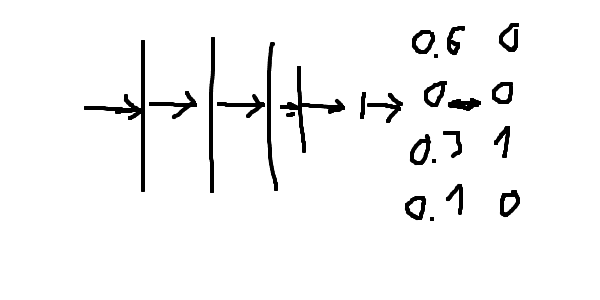

In [40]:
draw('drawing.png')